In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sys

import astropy as ap
from astropy.table import QTable

import read_mist_models

## Checking luminosity and radius

Checking if we can get the luminosity and the radius back from the data using formulas or if they also need to be predicted

### Pre-processing and functions

In [ ]:
def get_iso_data_panda(file):
    iso = read_mist_models.ISO(file)

    age = []
    logTeff = []
    logL = []
    log_g = []
    mass = []
    logR = []
    phase = []
    for iso_ind in range(len(iso.isos)):
        age.extend(iso.isos[iso_ind]['log10_isochrone_age_yr'])
        logTeff.extend(iso.isos[iso_ind]['log_Teff'])
        logL.extend(iso.isos[iso_ind]['log_L'])
        log_g.extend(iso.isos[iso_ind]['log_g'])
        mass.extend(iso.isos[iso_ind]['star_mass'])
        logR.extend(iso.isos[iso_ind]['log_R'])
        phase.extend(iso.isos[iso_ind]['phase'])

    iso_data_all = QTable([age, logTeff, log_g, mass, logL, logR, phase],
                        names=('age', 'logTeff', 'log_g', "mass", "logL", "logR", "phase"),
                        meta={'name': "iso data"})
    return iso_data_all.to_pandas()

In [44]:
full_data = get_iso_data_panda("data/MIST_v1.2_vvcrit0.0_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_basic.txt")

Reading in: data/MIST_v1.2_vvcrit0.0_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_basic.txt


In [45]:
display(full_data)

,age,logTeff,log_g,mass,logL,logR,phase
0,5.0,3.468541,3.116651,0.100000,-0.849695,0.160747,-1.0
1,5.0,3.469176,3.114042,0.101392,-0.839643,0.164503,-1.0
2,5.0,3.471116,3.106133,0.105660,-0.808944,0.175973,-1.0
3,5.0,3.473035,3.098417,0.109915,-0.778564,0.187325,-1.0
4,5.0,3.474944,3.090875,0.114180,-0.748368,0.198605,-1.0
...,...,...,...,...,...,...,...
103984,10.3,4.370643,7.779334,0.528715,-1.180793,-1.809005,6.0
103985,10.3,4.363336,7.782175,0.528717,-1.212858,-1.810425,6.0
103986,10.3,4.356026,7.784962,0.528720,-1.244886,-1.811817,6.0
103987,10.3,4.348711,7.787695,0.528724,-1.276875,-1.813182,6.0


In [46]:
#R/R_0 = np.sqrt((M/M_0) * 10**(log_g_0 - log_g))
# M/M_0 = val colonne "mass", log_g_0 = 4.4381, log_g = val colonne "log_g"
# -> on a le rayon en rayon solaire => se vérifie avec 10**ce qu'il y a dans la colonne "logR"

#L/L_0 = (R/R_0) * 10**(4*(log_Teff - log_Teff_0))
# R/R_0 = résultat d'avant OU 10**ce qu'il y a dans la colonne "logR", log_Teff = ce qu'il y a dans la colonne "logTeff",
# log_T_eff_0 = log10(5772) = 3.76132632
# -> on a la luminosité en luminosité solaire => se vérifie avec 10**ce qu'il y a dans la colonne "logL"

In [47]:
def calc_radius(mass, log_g, log_g_O = 4.4381):
    """
    mass in solar masses
    log_g in cm*s^-2
    log_g_O in cm*s^-2 is the log_g of the sun

    returns : radius in solar radiuses, log 10 of the radius in solar radiuses
    """
    radius = np.sqrt(mass * 10**(log_g_O - log_g))
    log_radius = np.log10(radius)
    return radius, log_radius

In [51]:
def calc_luminosity(radius, log_Teff, log_Teff_O = 3.76132632):
    """
    radius in solar radiuses
    log_Teff as the log 10 of the Teff in Kelvin
    log_Teff_O as the log 10 of the Teff of the sun in Kelvin

    returns : luminosity in solar luminosities, log 10 of the luminosity in solar luminosities
    """
    luminosity = radius**2 * 10**(4*(log_Teff - log_Teff_O))
    log_luminosity = np.log10(luminosity)
    return luminosity, log_luminosity

In [65]:
def pd_calc_L_R(row):
    # ret_dict = dict() continuer ça si je veux mais pas très utile

    radius, log_radius = calc_radius(row['mass'], row['log_g'])
    # ret_dict["radius"] = radius, log_radius
    luminosity, log_luminosity = calc_luminosity(radius, row['logTeff'])
    # luminosity, log_luminosity = calc_luminosity(10**row['logR'], row['logTeff'])
    # ret_dict["luminosity"] = luminosity, log_luminosity
    
    abs_radius_diff = abs(radius - 10**row['logR'])
    abs_luminosity_diff = abs(luminosity - 10**row['logL'])
    
    radius_diff = radius - 10**row['logR']
    luminosity_diff = luminosity - 10**row['logL']

    abs_log_radius_diff = abs(log_radius - row['logR'])
    abs_log_luminosity_diff = abs(log_luminosity - row['logL'])

    log_radius_diff = log_radius - row['logR']
    log_luminosity_diff = log_luminosity - row['logL']

    percentage_radius_diff = abs(1 - (10**row['logR'] / radius)) * 100
    percentage_luminosity_diff = abs(1 - (10**row['logL'] / luminosity)) * 100
    # cannot return the row variable as all of them become equal to the last row of the files
    ret_row = {"mass" : row['mass'], "phase" : row["phase"], "age" : row["age"], 
               "logR" : row["logR"], "logL" : row["logL"], "logTeff" : row["logTeff"], "log_g" : row["log_g"]}
    return abs_radius_diff, abs_luminosity_diff, abs_log_radius_diff, abs_log_luminosity_diff, \
            percentage_radius_diff, percentage_luminosity_diff, radius_diff, luminosity_diff, \
            log_radius_diff, log_luminosity_diff, ret_row

In [66]:
radius, log_radius = calc_radius(0.1, 3.116651)
print(radius, log_radius)
print(calc_luminosity(radius, 3.468541))

1.447853098896834 0.16072450000000016
(np.float64(0.1413538754859973), np.float64(-0.8496922799999984))


### Getting the results

In [67]:
result = full_data.apply(pd_calc_L_R, axis=1)

In [68]:
radius_tol = 0.019 # everything is worse than 0.0000000001, everything is better than 0.019
luminosity_tol = 3.08 # everything is worse than 0.00007, everything is better than 3.08
radius_count = 0
luminosity_count = 0

for res in result:
    if abs(res[2]) > radius_tol:
        radius_count += 1
    if abs(res[3]) > luminosity_tol:
        luminosity_count += 1

print("radius : ", radius_count)
print("luminosity : ", luminosity_count)

radius :  0
luminosity :  0


### Graph plotting

#### All the data

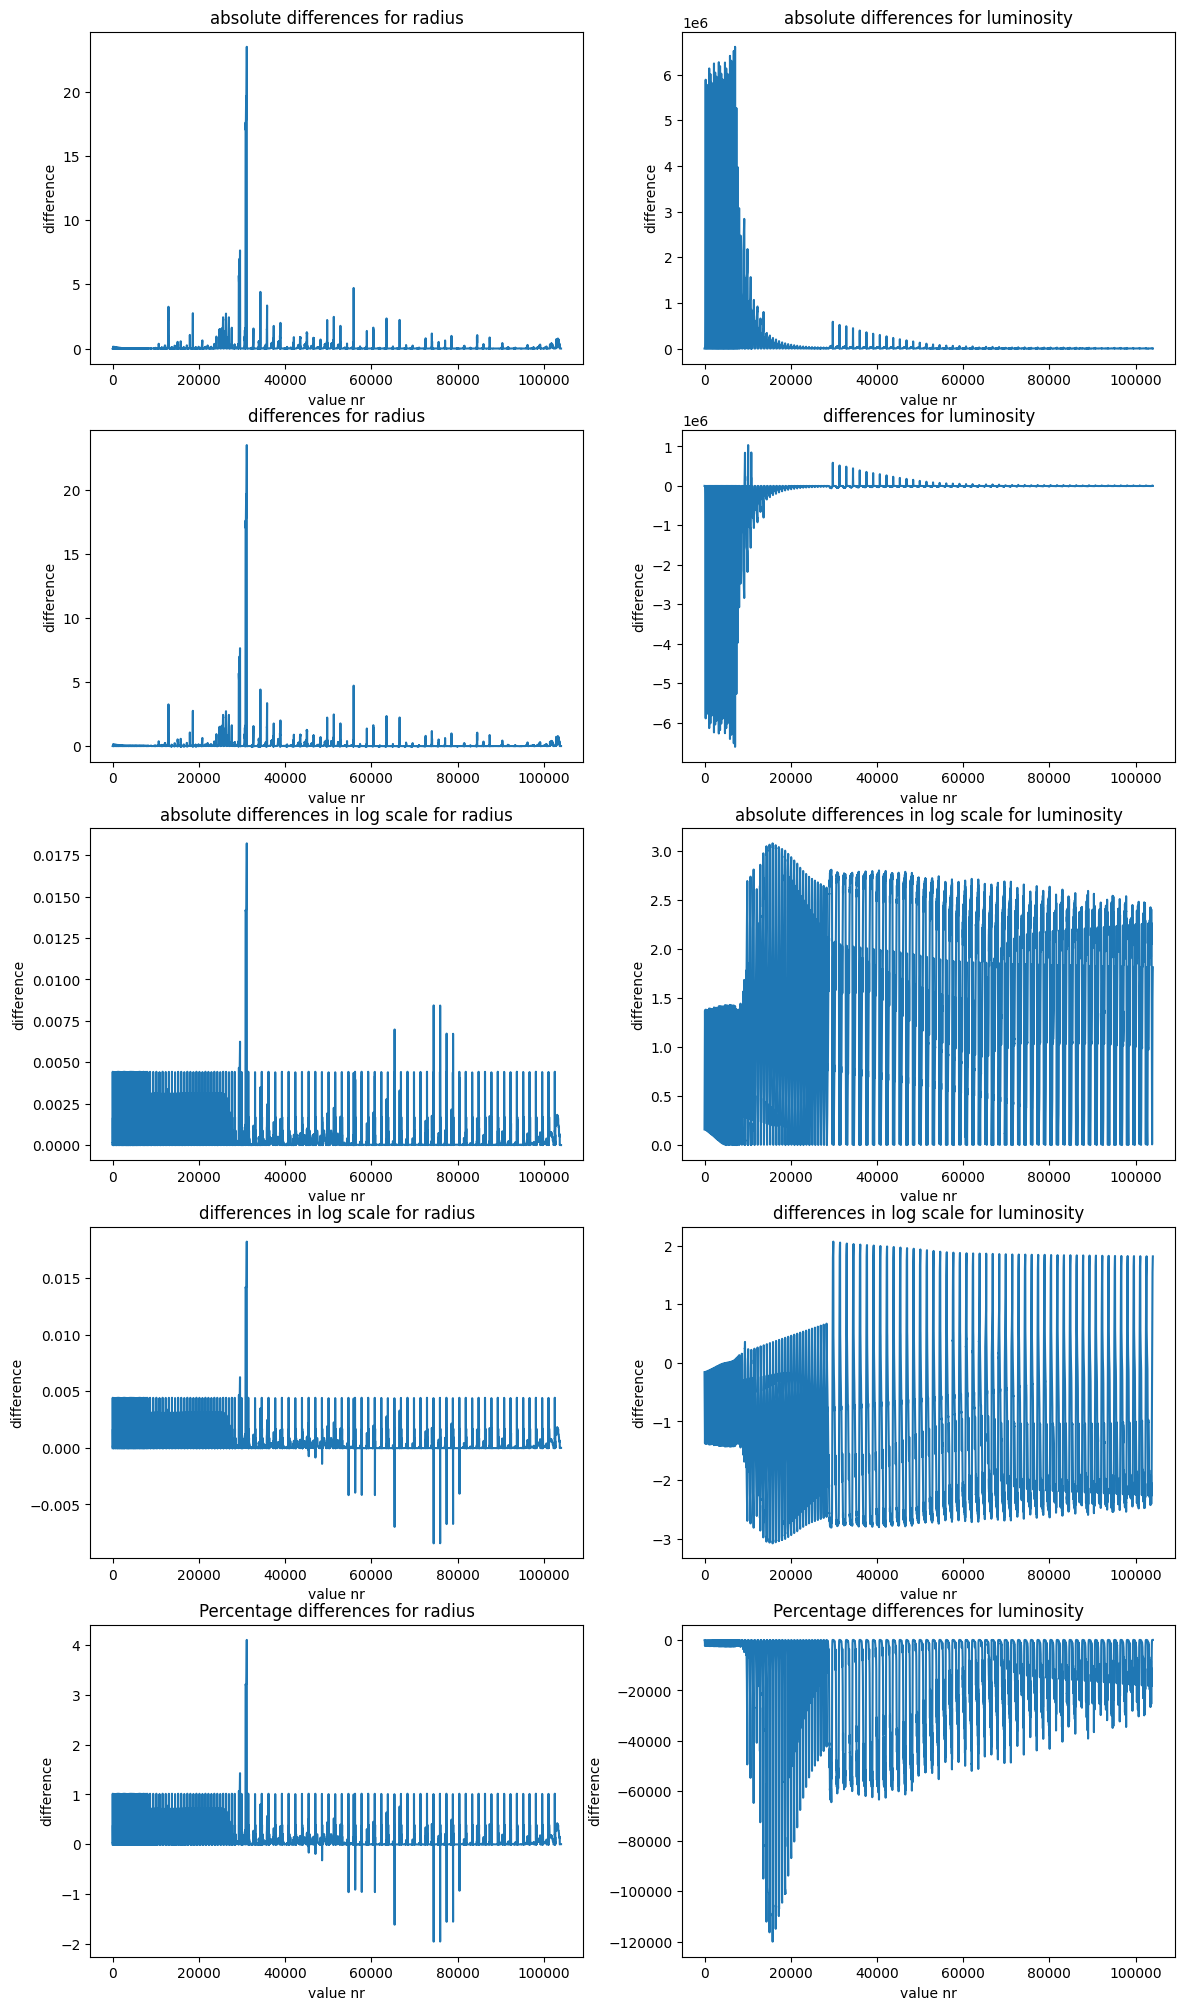

In [21]:
fig, ax = plt.subplots(5, 2, figsize=(14, 25))

radius_abs = []
luminosity_abs = []

radius_diff = []
luminosity_diff = []

radius_abs_log = []
luminosity_abs_log = []

radius_log_diff = []
luminosity_log_diff = []

radius_percent = []
luminosity_percent = []

for res in result:
    radius_abs.append(res[0])
    luminosity_abs.append(res[1])

    radius_diff.append(res[6])
    luminosity_diff.append(res[7])

    radius_abs_log.append(res[2])
    luminosity_abs_log.append(res[3])

    radius_log_diff.append(res[8])
    luminosity_log_diff.append(res[9])

    radius_percent.append(res[4])
    luminosity_percent.append(res[5])


ax[0, 0].set_title("absolute differences for radius")
ax[0, 0].set_xlabel("value nr")
ax[0, 0].set_ylabel("difference")
ax[0, 0].plot(radius_abs)

ax[0, 1].set_title("absolute differences for luminosity")
ax[0, 1].set_xlabel("value nr")
ax[0, 1].set_ylabel("difference")
ax[0, 1].plot(luminosity_abs)

ax[1, 0].set_title("differences for radius")
ax[1, 0].set_xlabel("value nr")
ax[1, 0].set_ylabel("difference")
ax[1, 0].plot(radius_diff)

ax[1, 1].set_title("differences for luminosity")
ax[1, 1].set_xlabel("value nr")
ax[1, 1].set_ylabel("difference")
ax[1, 1].plot(luminosity_diff)


ax[2, 0].set_title("absolute differences in log scale for radius")
ax[2, 0].set_xlabel("value nr")
ax[2, 0].set_ylabel("difference")
ax[2, 0].plot(radius_abs_log)

ax[2, 1].set_title("absolute differences in log scale for luminosity")
ax[2, 1].set_xlabel("value nr")
ax[2, 1].set_ylabel("difference")
ax[2, 1].plot(luminosity_abs_log)

ax[3, 0].set_title("differences in log scale for radius")
ax[3, 0].set_xlabel("value nr")
ax[3, 0].set_ylabel("difference")
ax[3, 0].plot(radius_log_diff)

ax[3, 1].set_title("differences in log scale for luminosity")
ax[3, 1].set_xlabel("value nr")
ax[3, 1].set_ylabel("difference")
ax[3, 1].plot(luminosity_log_diff)


ax[4, 0].set_title("Percentage differences for radius")
ax[4, 0].set_xlabel("value nr")
ax[4, 0].set_ylabel("difference")
ax[4, 0].plot(radius_percent)

ax[4, 1].set_title("Percentage differences for luminosity")
ax[4, 1].set_xlabel("value nr")
ax[4, 1].set_ylabel("difference")
ax[4, 1].plot(luminosity_percent)


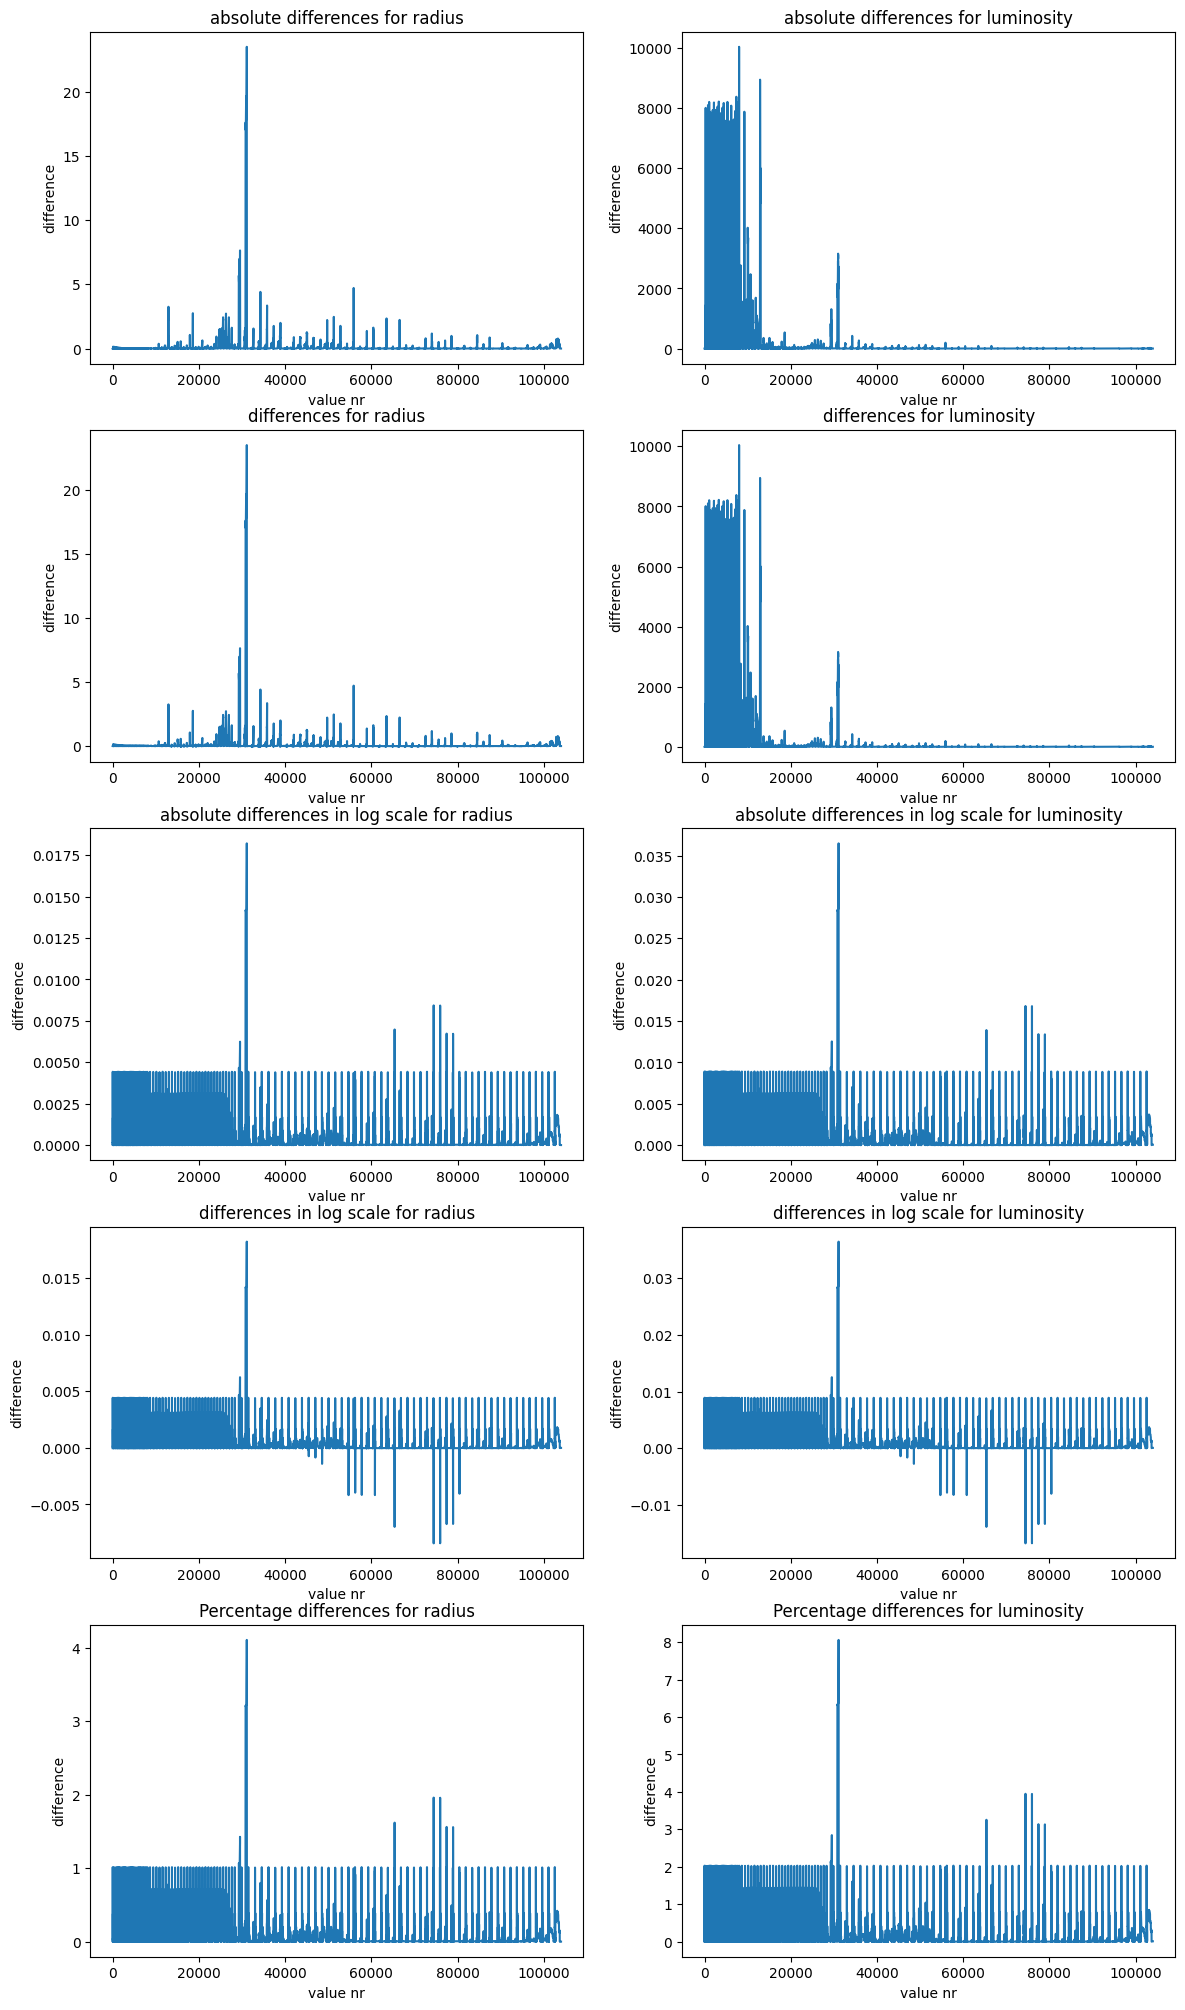

In [70]:
fig, ax = plt.subplots(5, 2, figsize=(14, 25))

radius_abs = []
luminosity_abs = []

radius_diff = []
luminosity_diff = []

radius_abs_log = []
luminosity_abs_log = []

radius_log_diff = []
luminosity_log_diff = []

radius_percent = []
luminosity_percent = []

for res in result:
    radius_abs.append(res[0])
    luminosity_abs.append(res[1])

    radius_diff.append(res[6])
    luminosity_diff.append(res[7])

    radius_abs_log.append(res[2])
    luminosity_abs_log.append(res[3])

    radius_log_diff.append(res[8])
    luminosity_log_diff.append(res[9])

    radius_percent.append(res[4])
    luminosity_percent.append(res[5])


ax[0, 0].set_title("absolute differences for radius")
ax[0, 0].set_xlabel("value nr")
ax[0, 0].set_ylabel("difference")
ax[0, 0].plot(radius_abs)

ax[0, 1].set_title("absolute differences for luminosity")
ax[0, 1].set_xlabel("value nr")
ax[0, 1].set_ylabel("difference")
ax[0, 1].plot(luminosity_abs)

ax[1, 0].set_title("differences for radius")
ax[1, 0].set_xlabel("value nr")
ax[1, 0].set_ylabel("difference")
ax[1, 0].plot(radius_diff)

ax[1, 1].set_title("differences for luminosity")
ax[1, 1].set_xlabel("value nr")
ax[1, 1].set_ylabel("difference")
ax[1, 1].plot(luminosity_diff)


ax[2, 0].set_title("absolute differences in log scale for radius")
ax[2, 0].set_xlabel("value nr")
ax[2, 0].set_ylabel("difference")
ax[2, 0].plot(radius_abs_log)

ax[2, 1].set_title("absolute differences in log scale for luminosity")
ax[2, 1].set_xlabel("value nr")
ax[2, 1].set_ylabel("difference")
ax[2, 1].plot(luminosity_abs_log)

ax[3, 0].set_title("differences in log scale for radius")
ax[3, 0].set_xlabel("value nr")
ax[3, 0].set_ylabel("difference")
ax[3, 0].plot(radius_log_diff)

ax[3, 1].set_title("differences in log scale for luminosity")
ax[3, 1].set_xlabel("value nr")
ax[3, 1].set_ylabel("difference")
ax[3, 1].plot(luminosity_log_diff)


ax[4, 0].set_title("Percentage differences for radius")
ax[4, 0].set_xlabel("value nr")
ax[4, 0].set_ylabel("difference")
ax[4, 0].plot(radius_percent)

ax[4, 1].set_title("Percentage differences for luminosity")
ax[4, 1].set_xlabel("value nr")
ax[4, 1].set_ylabel("difference")
ax[4, 1].plot(luminosity_percent)


#### Test with less points
To manually check why the error is so large in the luminosity

In [42]:
count_m1 = 0 # PMS
count_0 = 0 # MS
count_p2 = 0 # RGB
count_p3 = 0 # CHeB
count_p4 = 0 # EAGB
count_p5 = 0 # TPAGB
count_p6 = 0 # postAGB
count_p9 = 0 # WR

for res in result:
    if res[-1]["phase"] == -1:
        count_m1 += 1
    elif res[-1]["phase"] == 0:
        count_0 += 1
    elif res[-1]["phase"] == 2:
        count_p2 += 1
    elif res[-1]["phase"] == 3:
        count_p3 += 1
    elif res[-1]["phase"] == 4:
        count_p4 += 1
    elif res[-1]["phase"] == 5:
        count_p5 += 1
    elif res[-1]["phase"] == 6:
        count_p6 += 1
    elif res[-1]["phase"] == 9:
        count_p9 += 1
    else:
        print("not ok")

print(count_m1)
print(count_0)
print(count_p2)
print(count_p3)
print(count_p4)
print(count_p5)
print(count_p6)
print(count_p9)

8160
22629
11627
7842
8199
29467
14798
1267


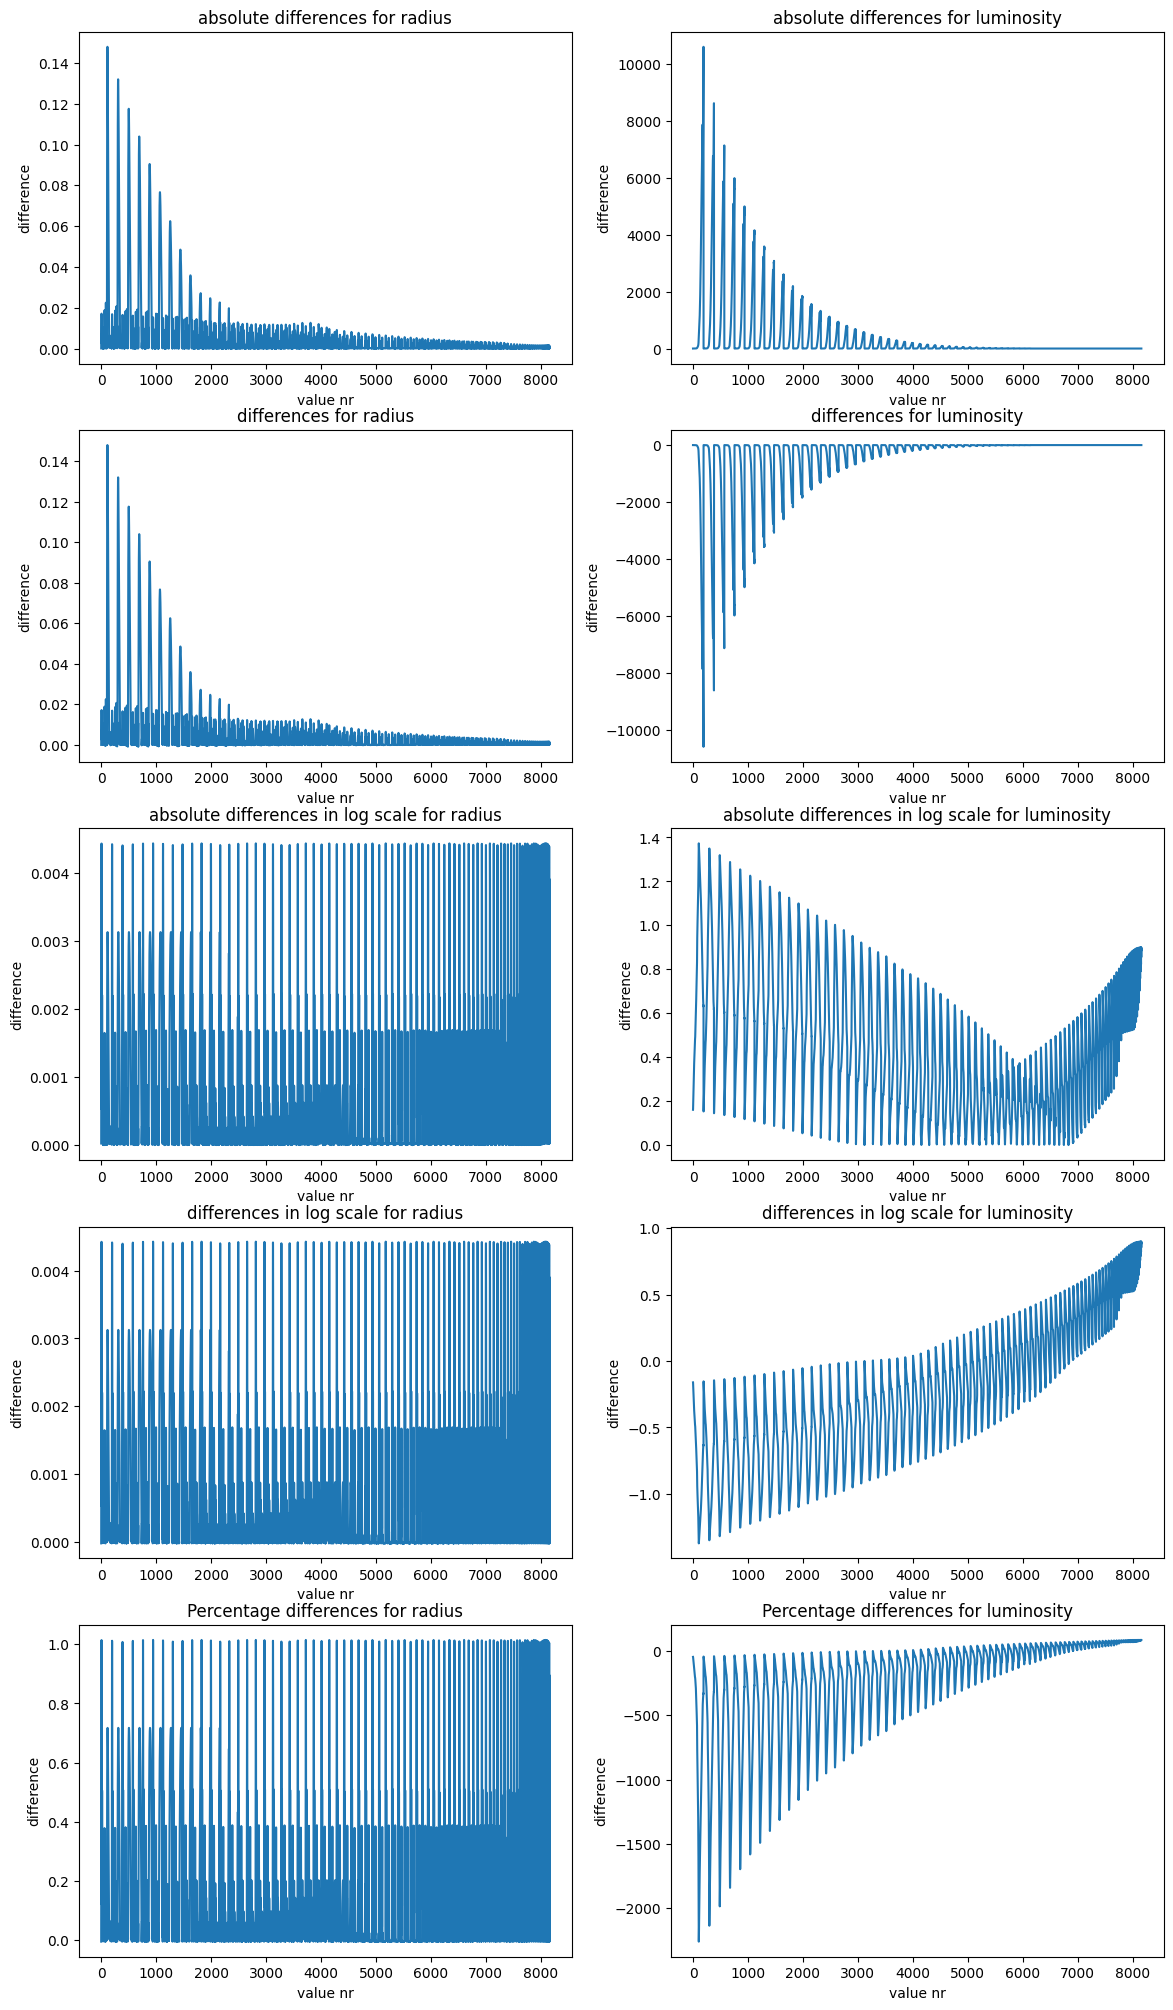

In [22]:
fig, ax = plt.subplots(5, 2, figsize=(14, 25))

radius_abs = []
luminosity_abs = []

radius_diff = []
luminosity_diff = []

radius_abs_log = []
luminosity_abs_log = []

radius_log_diff = []
luminosity_log_diff = []

radius_percent = []
luminosity_percent = []

for res in result:
    if res[-1]["phase"] == -1:
        radius_abs.append(res[0])
        luminosity_abs.append(res[1])

        radius_diff.append(res[6])
        luminosity_diff.append(res[7])

        radius_abs_log.append(res[2])
        luminosity_abs_log.append(res[3])

        radius_log_diff.append(res[8])
        luminosity_log_diff.append(res[9])

        radius_percent.append(res[4])
        luminosity_percent.append(res[5])


ax[0, 0].set_title("absolute differences for radius")
ax[0, 0].set_xlabel("value nr")
ax[0, 0].set_ylabel("difference")
ax[0, 0].plot(radius_abs)

ax[0, 1].set_title("absolute differences for luminosity")
ax[0, 1].set_xlabel("value nr")
ax[0, 1].set_ylabel("difference")
ax[0, 1].plot(luminosity_abs)

ax[1, 0].set_title("differences for radius")
ax[1, 0].set_xlabel("value nr")
ax[1, 0].set_ylabel("difference")
ax[1, 0].plot(radius_diff)

ax[1, 1].set_title("differences for luminosity")
ax[1, 1].set_xlabel("value nr")
ax[1, 1].set_ylabel("difference")
ax[1, 1].plot(luminosity_diff)


ax[2, 0].set_title("absolute differences in log scale for radius")
ax[2, 0].set_xlabel("value nr")
ax[2, 0].set_ylabel("difference")
ax[2, 0].plot(radius_abs_log)

ax[2, 1].set_title("absolute differences in log scale for luminosity")
ax[2, 1].set_xlabel("value nr")
ax[2, 1].set_ylabel("difference")
ax[2, 1].plot(luminosity_abs_log)

ax[3, 0].set_title("differences in log scale for radius")
ax[3, 0].set_xlabel("value nr")
ax[3, 0].set_ylabel("difference")
ax[3, 0].plot(radius_log_diff)

ax[3, 1].set_title("differences in log scale for luminosity")
ax[3, 1].set_xlabel("value nr")
ax[3, 1].set_ylabel("difference")
ax[3, 1].plot(luminosity_log_diff)


ax[4, 0].set_title("Percentage differences for radius")
ax[4, 0].set_xlabel("value nr")
ax[4, 0].set_ylabel("difference")
ax[4, 0].plot(radius_percent)

ax[4, 1].set_title("Percentage differences for luminosity")
ax[4, 1].set_xlabel("value nr")
ax[4, 1].set_ylabel("difference")
ax[4, 1].plot(luminosity_percent)

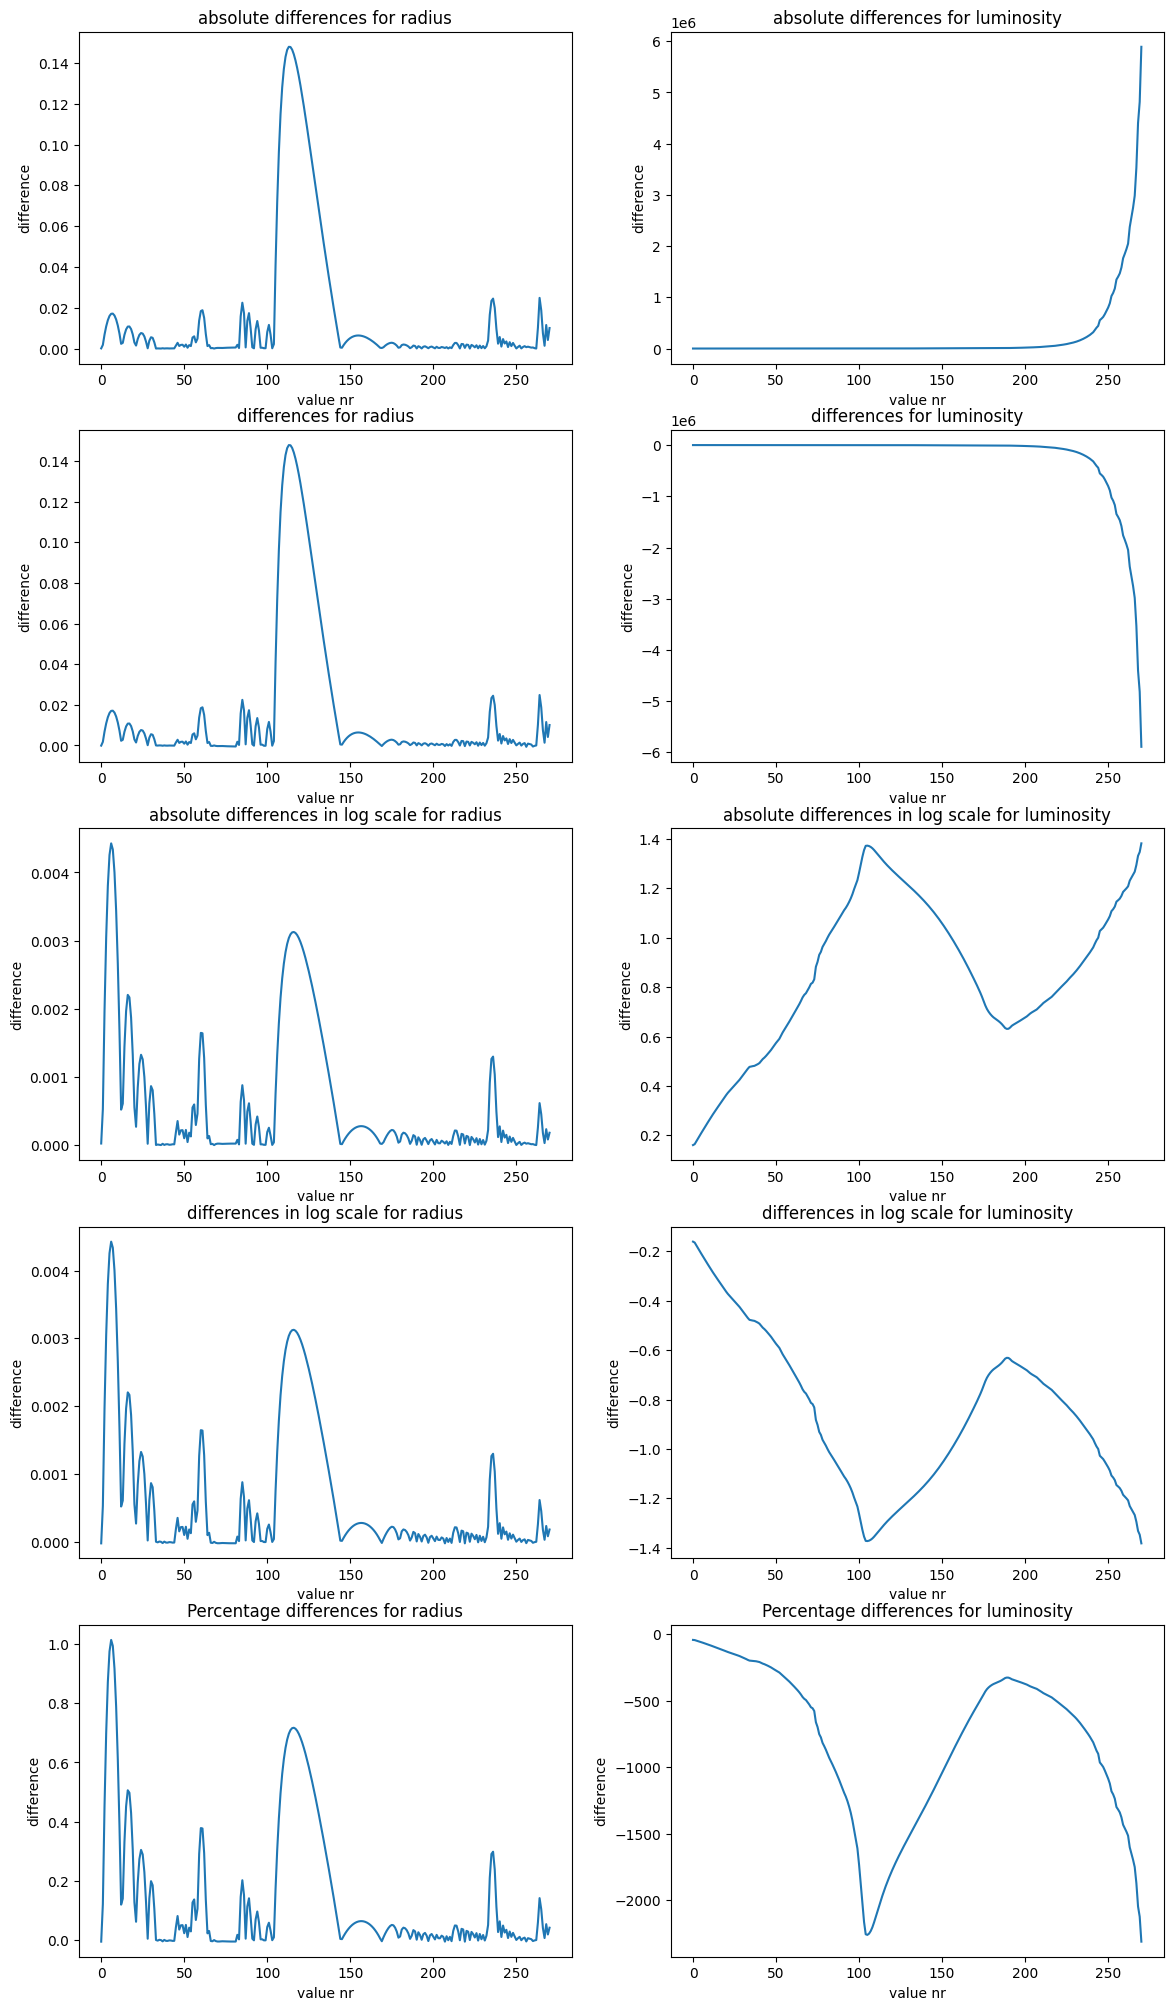

In [23]:
fig, ax = plt.subplots(5, 2, figsize=(14, 25))

radius_abs = []
luminosity_abs = []

radius_diff = []
luminosity_diff = []

radius_abs_log = []
luminosity_abs_log = []

radius_log_diff = []
luminosity_log_diff = []

radius_percent = []
luminosity_percent = []

for res in result:
    if res[-1]["age"] == 5:
        radius_abs.append(res[0])
        luminosity_abs.append(res[1])

        radius_diff.append(res[6])
        luminosity_diff.append(res[7])

        radius_abs_log.append(res[2])
        luminosity_abs_log.append(res[3])

        radius_log_diff.append(res[8])
        luminosity_log_diff.append(res[9])

        radius_percent.append(res[4])
        luminosity_percent.append(res[5])


ax[0, 0].set_title("absolute differences for radius")
ax[0, 0].set_xlabel("value nr")
ax[0, 0].set_ylabel("difference")
ax[0, 0].plot(radius_abs)

ax[0, 1].set_title("absolute differences for luminosity")
ax[0, 1].set_xlabel("value nr")
ax[0, 1].set_ylabel("difference")
ax[0, 1].plot(luminosity_abs)

ax[1, 0].set_title("differences for radius")
ax[1, 0].set_xlabel("value nr")
ax[1, 0].set_ylabel("difference")
ax[1, 0].plot(radius_diff)

ax[1, 1].set_title("differences for luminosity")
ax[1, 1].set_xlabel("value nr")
ax[1, 1].set_ylabel("difference")
ax[1, 1].plot(luminosity_diff)


ax[2, 0].set_title("absolute differences in log scale for radius")
ax[2, 0].set_xlabel("value nr")
ax[2, 0].set_ylabel("difference")
ax[2, 0].plot(radius_abs_log)

ax[2, 1].set_title("absolute differences in log scale for luminosity")
ax[2, 1].set_xlabel("value nr")
ax[2, 1].set_ylabel("difference")
ax[2, 1].plot(luminosity_abs_log)

ax[3, 0].set_title("differences in log scale for radius")
ax[3, 0].set_xlabel("value nr")
ax[3, 0].set_ylabel("difference")
ax[3, 0].plot(radius_log_diff)

ax[3, 1].set_title("differences in log scale for luminosity")
ax[3, 1].set_xlabel("value nr")
ax[3, 1].set_ylabel("difference")
ax[3, 1].plot(luminosity_log_diff)


ax[4, 0].set_title("Percentage differences for radius")
ax[4, 0].set_xlabel("value nr")
ax[4, 0].set_ylabel("difference")
ax[4, 0].plot(radius_percent)

ax[4, 1].set_title("Percentage differences for luminosity")
ax[4, 1].set_xlabel("value nr")
ax[4, 1].set_ylabel("difference")
ax[4, 1].plot(luminosity_percent)

In [42]:
# checking value nr 105 ce qui correspond à l'EEP 115 dans le fichier
eep = result[105][-1]
for key in eep:
    print(f"{key} : {eep[key]}")

radius = calc_radius(eep["mass"], eep["log_g"])
luminosity = calc_luminosity(10**eep["logR"], eep["logTeff"])
print(f"radius : {radius[0]}, log_radius : {radius[1]}")
print(f"luminosity : {luminosity[0]}, log_luminosity : {luminosity[1]}")

luminosity_2 = (10**eep["logR"])**2 * 10**(4*(eep["logTeff"] - 3.76132632))
print(luminosity_2)

print(10**eep['logL'])

# abs_radius_diff = abs(radius - 10**row['logR'])
# abs_luminosity_diff = abs(luminosity - 10**row['logL'])

# radius_diff = radius - 10**row['logR']
# luminosity_diff = luminosity - 10**row['logL']

# abs_log_radius_diff = abs(log_radius - row['logR'])
# abs_log_luminosity_diff = abs(log_luminosity - row['logL'])

# log_radius_diff = log_radius - row['logR']
# log_luminosity_diff = log_luminosity - row['logL']

# percentage_radius_diff = (1 - (10**row['logR'] / radius)) * 100
# percentage_luminosity_diff = (1 - (10**row['logL'] / luminosity)) * 100


mass : 6.552923124678914
phase : -1.0
age : 5.0
logR : 1.373126953094099
logL : 2.653295194387492
logTeff : 3.7380988981408803
log_g : 2.506780736414534
23.6116834975315 3.7380988981408803 3.76132632
19.06414206355845
19.06414206355845
radius : 23.652506381713067, log_radius : 1.373877168332715
luminosity : 19.06414206355845, log_luminosity : 1.280217265657621
450.13648855671914
450.08567877072215
